# Réglages `Google Collab` 
Connexion au Drive pour accéder au réseau de neurones et aux données néssaires pour la classification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Ressources

[Code et base de données à récupérer]

Le code et la base de données pour la classification de tableau est accessible ici https://github.com/bnegreve/rasta


#1. Classification de peinture

Dans cette partie, nous cherchons à différiencer les tableaux abstraits de ceux qui ne le sont pas afin d'y appliquer l'algorithme d'estimation de la profondeur le plus adapté.


In [ ]:
!pip3 install -r /content/drive/MyDrive/classification/python/requirements.txt
!pip3 install tensorflow-gpu

In [ ]:
!wget www.lamsade.dauphine.fr/~bnegrevergne/webpage/software/rasta/rasta_models.tgz
!tar xzvf rasta_models.tgz

Test sur l'image "fruits.tif"



In [ ]:
!python3 /content/drive/MyDrive/classification/python/evaluation.py -t pred  --data_path=/content/drive/MyDrive/classification/data/wikipaintings_small/wikipaintings_test/High_Renaissance/andrea-del-sarto_stories-of-joseph-1.jpg

#2. Estimation de la profondeur
Nous cherchons à estimer la profondeur de chaque pixel de deux manières différentes:
- à partir d'un réseau de neurones pré-entrainé 
- à partir de l'analyse des intensités par régions

## Calcul de profondeur avec un réseau de neurones

Téléchargement d'une bibliothèque nécessaire

In [ ]:
!pip3 install onnxruntime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 KB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 KB 10.0 MB/s eta 0:00:00


Import des bibliothèques nécessaires

In [ ]:
import argparse
import os

import numpy as np
import onnxruntime as ort
from PIL import Image
from matplotlib import pyplot as plt

In [ ]:
model = "/content/drive/MyDrive/pact43/model.quant.onnx"
image_input = "/content/mondrian.jpg"
image_output = "depth_map.jpg"

In [ ]:
net_w = 512
net_h = 512

class DepthMap:
    def __init__(self, model_path = model):
        self.sess = ort.InferenceSession(model_path)

    def prepare_input(self, image: Image):
        width, height = image.size
        img_input = image.resize((net_w, net_h))
        img_input = np.asanyarray(img_input) / 255.0
        img_input = img_input.transpose((2, 0, 1))
        img_input = img_input.reshape(1, 3, net_h, net_w)
        img_input = img_input.astype(np.float32)
        return img_input, (width, height)

    def predict(self, img_input: np.ndarray):
        out = self.sess.run(None, {'input': img_input})
        return out[0]

    def post_process(self, depth, width, height):
        depth = np.array(depth).reshape(net_h, net_w)
        depth = Image.fromarray(depth)
        depth = depth.resize((width, height), Image.BICUBIC)
        depth = np.asanyarray(depth)

        depth_min = depth.min()
        depth_max = depth.max()

        bits = 2
        max_val = (2**(8*bits))-1

        if depth_max - depth_min > np.finfo("float").eps:
            out = max_val * (depth - depth_min) / (depth_max - depth_min)
        else:
            out = np.zeros(depth.shape, dtype=depth.type)
        return out

    def __call__(self, img: Image):
        img_input, (width, height) = self.prepare_input(img)
        depth = self.predict(img_input)
        out = self.post_process(depth, width, height)
        return out

In [ ]:
depth_map = DepthMap(model)

img = Image.open(image_input)

depth_array = depth_map(img)

Sauvegarde des couleurs des pixels de l'image originale

In [ ]:
colors_pixels = np.array(img)
colors_pixels = colors_pixels.reshape(-1,3)

#np.save('colors.npy', colors_pixels)

Comparaison de l'image originale et de sa carte de profondeur

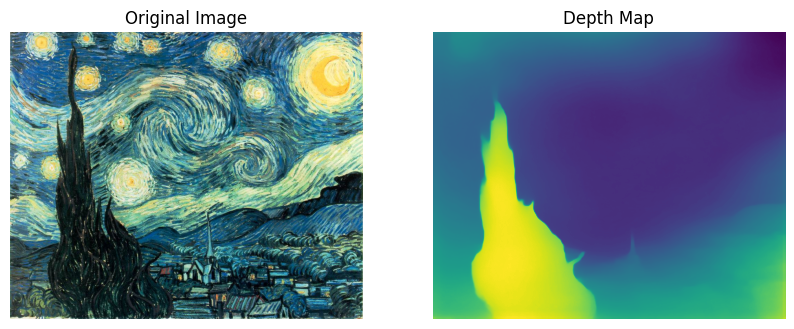

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img)
ax[0].set_title('Original Image')
ax[1].imshow(depth_array)
ax[1].set_title('Depth Map')
for a in ax:
    a.set_axis_off()

plt.show()

Sauvegarde de la carte de profondeur en tableau `.npy`

In [ ]:
np.save('depth_array.npy', depth_array)

In [ ]:
np.savetxt('depth_array.txt', depth_array, delimiter=',')

## Calcul de profondeur par analyse des intensités des régions de l'image

On utilisera au préalable `SLIC`. Elle permet la segmentation d’une image en superpixels. En comparaison avec d’autres algorithmes de segmentation basés
superpixels, SLIC apparaît comme le meilleur compromis entre efficacité en temps et en mémoire
(complexité linéaire en fonction du nombre de pixels dans l’image et indépendante du nombre de superpixels), précision de l’adhérence aux contours de l’image et contrôle sur le nombre et la taille des
superpixels.

In [ ]:
import numpy as np
import cv2
from PIL import Image
from matplotlib import pyplot as plt


from skimage.color import rgb2gray, rgb2lab
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

In [ ]:
image_input = "/content/mondrian.jpg"
image_output = "depth_2.jpg"

img = cv2.imread(image_input)
img_ff = img_as_float(plt.imread(image_input))


# Code

Idée
Filtre médian + dbscan image après slic
https://experiencor.github.io/segmentation.html

On applique la ségmentation `slic` à l'image pour séparer les régions puis on calcule la moyenne des couleurs de chaques régions puis on remplace la couleurs de tous les pixels de chaque par la couleur moyenne, on obtient alors u neffet mosaïque. Enfin, on passse l'image en noir et blanc pour avoir une carte de profondeur.

In [ ]:
region_slic = slic(img_ff, n_segments=250, compactness=10, sigma=1,
                     start_label=1)

In [ ]:
img_mean = np.zeros_like(img_ff)
mean_colors = []
for label in np.unique(region_slic):
    mask = (region_slic == label)
    mean_color = np.mean(img_ff[mask], axis=0)
    mean_colors.append(mean_color)
    img_mean[mask] = mean_color

In [ ]:
img_int8 = Image.fromarray((img_mean * 255).astype(np.uint8))
img_int8 = np.array(img_int8, dtype=np.uint8)
img_hsv = cv2.cvtColor(img_int8, cv2.COLOR_BGR2HSV )

In [ ]:
depth_array_slic = np.asarray(rgb2gray(img_mean))

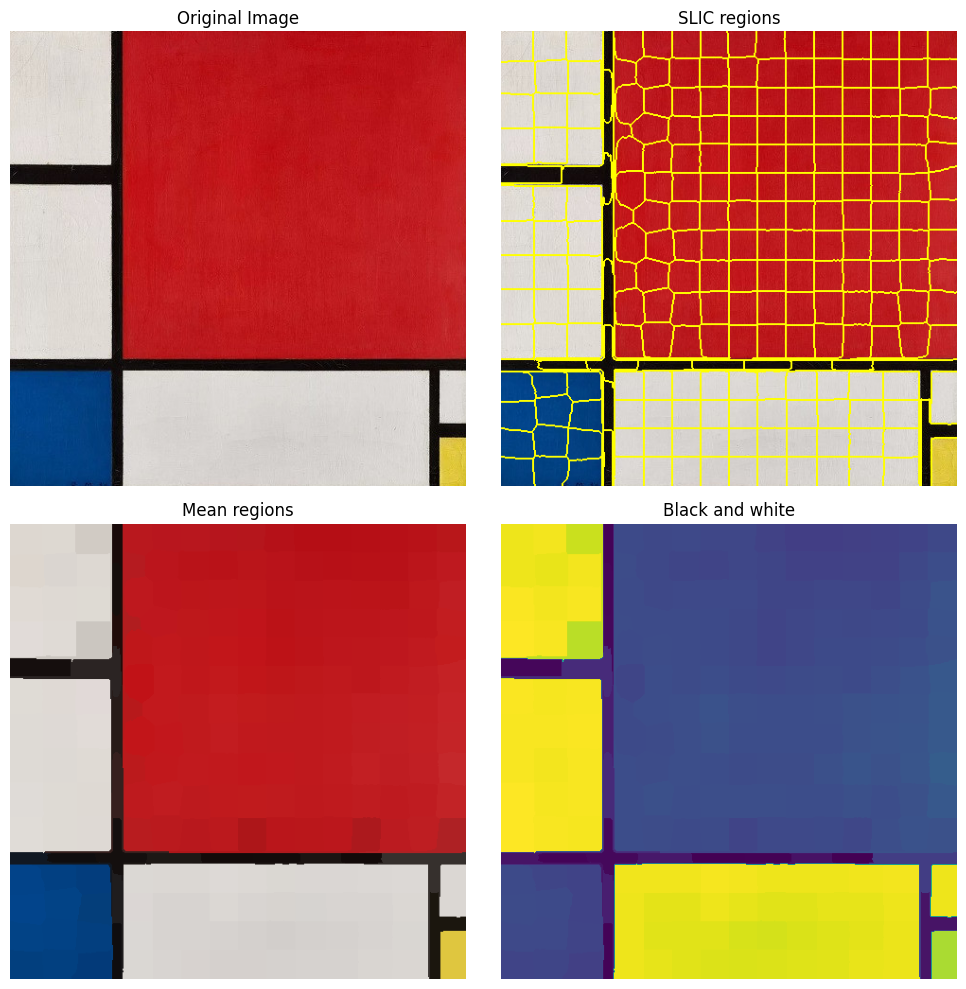

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].imshow(img_ff)
ax[0, 0].set_title("Original Image")
ax[0, 1].imshow(mark_boundaries(img_ff, region_slic))
ax[0, 1].set_title('SLIC regions')
ax[1, 0].imshow(img_mean)
ax[1, 0].set_title('Mean regions')
ax[1, 1].imshow(depth_array_slic)
ax[1, 1].set_title('Black and white')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

## Autres test

In [ ]:
lab_img = rgb2lab(img_ff)

max_sp_width = 50
max_sp_height = 50

img_shape = lab_img.shape[:2]
num_sp = max_sp_width * max_sp_height

compactness = 10 * img_shape[0] * img_shape[1] / (num_sp ** 2)

segments_slic_adjust = slic(lab_img, n_segments=num_sp, compactness=compactness)

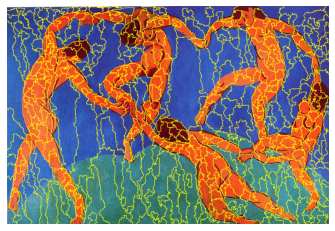

In [ ]:
plt.imshow(mark_boundaries(img_ff, segments_slic_adjust))
plt.axis("off")
plt.show()

## Comparaison avec d'autres méthodes

Felzenszwalb number of segments: 3188
SLIC number of segments: 213
Quickshift number of segments: 7191
Compact watershed number of segments: 252


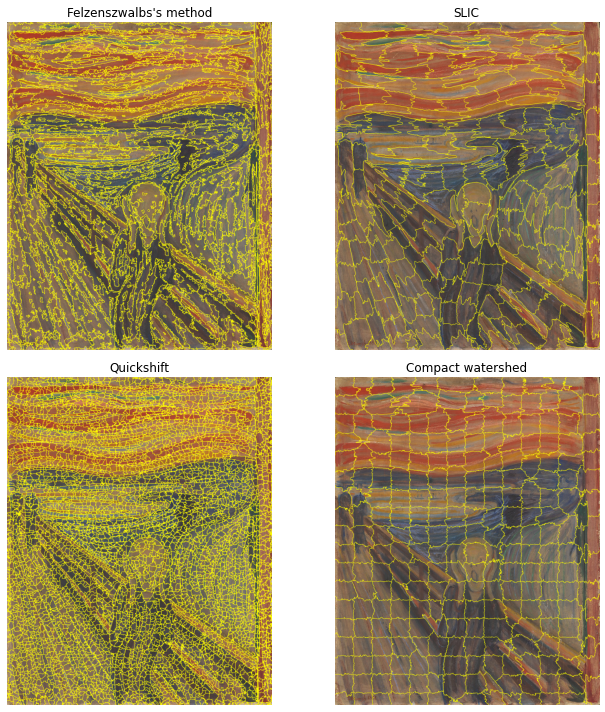

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

img_c = img_as_float(plt.imread(image_input))

segments_fz = felzenszwalb(img_c, scale=100, sigma=0.5, min_size=50)
segments_slic = slic(img_c, n_segments=250, compactness=10, sigma=1,
                     start_label=1)
segments_quick = quickshift(img_c, kernel_size=3, max_dist=6, ratio=0.5)
gradient = sobel(rgb2gray(img_c))
segments_watershed = watershed(gradient, markers=250, compactness=0.001)

print(f'Felzenszwalb number of segments: {len(np.unique(segments_fz))}')
print(f'SLIC number of segments: {len(np.unique(segments_slic))}')
print(f'Quickshift number of segments: {len(np.unique(segments_quick))}')
print(f'Compact watershed number of segments: {len(np.unique(segments_watershed))}')


fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].imshow(mark_boundaries(img_c, segments_fz))
ax[0, 0].set_title("Felzenszwalbs's method")
ax[0, 1].imshow(mark_boundaries(img_c, segments_slic))
ax[0, 1].set_title('SLIC')
ax[1, 0].imshow(mark_boundaries(img_c, segments_quick))
ax[1, 0].set_title('Quickshift')
ax[1, 1].imshow(mark_boundaries(img_c, segments_watershed))
ax[1, 1].set_title('Compact watershed')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

In [ ]:
regions = [segments_fz, segments_slic, segments_quick, segments_watershed]
img_means = []

for region in regions:
  img_mean = np.zeros_like(img_ff)
  mean_colors = []
  for label in np.unique(region):
      mask = (region == label)
      mean_color = np.mean(img_ff[mask], axis=0)
      mean_colors.append(mean_color)
      img_mean[mask] = mean_color
  img_means.append(img_mean)

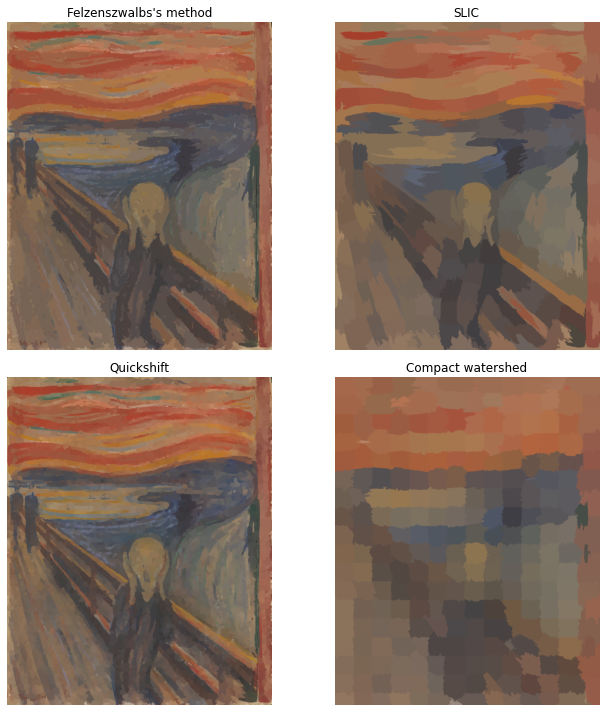

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].imshow(img_means[0])
ax[0, 0].set_title("Felzenszwalbs's method")
ax[0, 1].imshow(img_means[1])
ax[0, 1].set_title('SLIC')
ax[1, 0].imshow(img_means[2])
ax[1, 0].set_title('Quickshift')
ax[1, 1].imshow(img_means[3])
ax[1, 1].set_title('Compact watershed')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

In [ ]:
from scipy import ndimage 
median_image = ndimage.median_filter(img_means[1], 3)

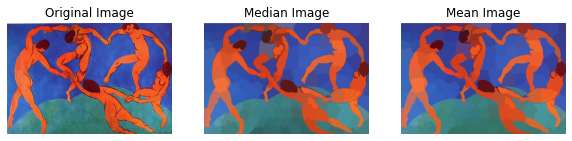

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(img_ff)
ax[0].set_title('Original Image')
ax[1].imshow(median_image)
ax[1].set_title('Median Image')
ax[2].imshow(img_means[1])
ax[2].set_title('Mean Image')
for a in ax:
    a.set_axis_off()

plt.show()

In [ ]:
im = Image.fromarray((img_means[1] * 255).astype(np.uint8))
im = np.array(im, dtype=np.uint8)
image = cv2.cvtColor(im, cv2.COLOR_BGR2HSV )

im = Image.fromarray((image * 255).astype(np.uint8))
im.save("your_file.jpg")

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN

img = image.copy()

Z = np.float32(im.reshape((-1,3)))
db = DBSCAN(eps=0.3, min_samples=100).fit(Z[:,:2])

plt.imshow(np.uint8(db.labels_.reshape(im.shape[:2])))
plt.show()

AttributeError: ignored

In [ ]:
import cv2
#import matplotlib.pyplot as plt
#import numpy as np
#from sklearn.cluster import DBSCAN

#image = img_mean

#Z = np.float32(image.reshape((-1,3)))
#db = DBSCAN(eps=0.3, min_samples=100).fit(Z[:,:2])

#img = np.uint8(db.labels_.reshape(image.shape[:2]))
#plt.show()

# Sauvegarde

In [ ]:
depth_array_slic = np.asarray(rgb2gray(image))

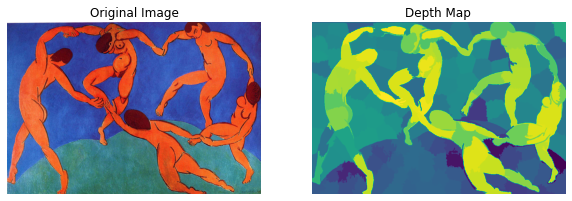

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_ff)
ax[0].set_title('Original Image')
ax[1].imshow(depth_array_slic)
ax[1].set_title('Depth Map')
for a in ax:
    a.set_axis_off()

plt.show()

Sauvegarde des couleurs des pixels de l'image originale

In [ ]:
img = Image.open(image_input)
colors_pixels = np.array(img)
colors_pixels = colors_pixels.reshape(-1,3)

Filtre majoritaire pour les

#3. Redimensionnement de la carte de profondeur
Nous redimensionnons la carte de profondeur afin qu'elle puisse correspondre aux nombre de picots de notre table en longueur et en largeur

## Méthode `Resize`classique (abandonnée)

In [ ]:
hauteur = 50 #hauteur max des picots
largeur = 50 #largeur de la table de picots
longueur = 22 #largeur de la table de picots

In [ ]:
depth_array_copy = depth_array.copy()
depth_array_copy.resize(longueur,largeur)
depth_array = cv2.normalize(depth_array_copy, None, 0, 1, cv2.NORM_MINMAX)
depth_array *= hauteur

## Méthode d'interpolation au plus proche voisin `Nearest`

L’interpolation par la méthode du voisin le plus proche consiste à donner au pixel interpolé la même valeur que celle du pixel voisin le plus proche. Cette méthode conserve la dynamique du champs original et ne créé pas de niveaux intermédiaires.



In [ ]:
data = depth_array_slic
data.shape

(482, 482)

In [ ]:
longueur = 50
largeur = 50

In [ ]:
depth_array_crop = np.array(Image.fromarray(data).resize((largeur, longueur), Image.NEAREST))

Comparaison des cartes de profondeur avant et après le sous-echantillonage

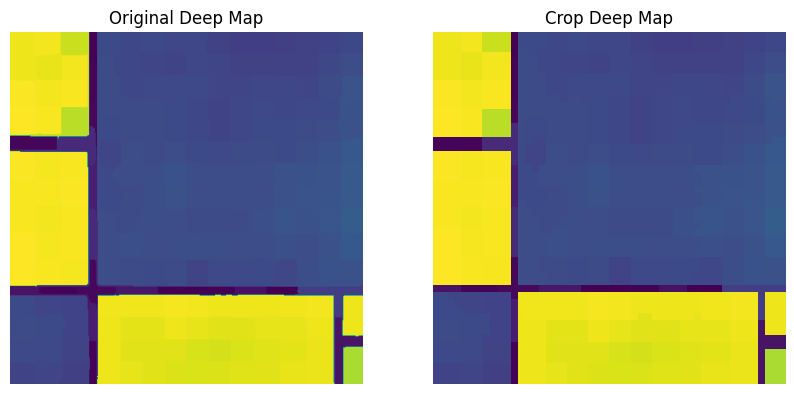

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(data)
ax[0].set_title('Original Deep Map')
ax[1].imshow(depth_array_crop)
ax[1].set_title('Crop Deep Map')
for a in ax:
    a.set_axis_off()

plt.show()

Sauvegarde

In [ ]:
#np.savetxt('depth_array.txt', depth_array_crop, delimiter=',')

NameError: ignored

Sauvegarde des nouvelles couleurs

In [ ]:
img_crop = np.array(img.resize((largeur, longueur), Image.NEAREST))
colors_pixels_crop = img_crop.reshape(-1,3)

TypeError: ignored

## Modification de la hauteur

In [ ]:
hauteur = 10
depth_array_h = (depth_array_crop / depth_array_crop.max()) * hauteur

## Création du modèle 3D et du fichier `.ply` avec `Open3D`

In [ ]:
!pip3 install open3d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.5/420.5 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 KB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 82.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 KB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 85.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 74.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.2 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.4
    Uninstalling widgetsnbextension-3.6.4:
      Successfully uninstalled widgetsnbextension-3.6.4
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.4.0
    Uninstalling Pillow-8.4.0:
      Successfully uninstalled Pi

In [ ]:
import open3d as o3d

### Création du fichier 3D

In [ ]:
vertices = []
depths = depth_array_h
colors = colors_pixels_crop

for x in range(depths.shape[0]):
    for y in range(depths.shape[1]):
        vertices.append((float(x), float(y), depths[x][y]))

pcd = o3d.geometry.PointCloud()

point_cloud = np.asarray(np.array(vertices))
pcd.points = o3d.utility.Vector3dVector(point_cloud)
pcd.estimate_normals()
pcd = pcd.normalize_normals()

pcd.colors = o3d.utility.Vector3dVector(tuple(map(tuple, colors / 255.0)))

o3d.io.write_point_cloud("data.ply", pcd)

True

# Sous-Echantillonage du modèle 3D (*abandonné*)
Quelques tests de sous-échantillognage du modèle

## Sous-echantillonage par grille
https://towardsdatascience.com/how-to-automate-lidar-point-cloud-processing-with-python-a027454a536c


In [ ]:
def grid_subsampling(points, voxel_size):

  nb_vox=np.ceil((np.max(points, axis=0) - np.min(points, axis=0))/voxel_size)
  non_empty_voxel_keys, inverse, nb_pts_per_voxel= np.unique(((points - np.min(points, axis=0)) // voxel_size).astype(int), axis=0, return_inverse=True, return_counts=True)
  idx_pts_vox_sorted=np.argsort(inverse)
  voxel_grid={}
  grid_barycenter,grid_candidate_center=[],[]
  last_seen=0

  for idx,vox in enumerate(non_empty_voxel_keys):
    voxel_grid[tuple(vox)]=points[idx_pts_vox_sorted[last_seen:last_seen+nb_pts_per_voxel[idx]]]
    grid_barycenter.append(np.mean(voxel_grid[tuple(vox)],axis=0))
    grid_candidate_center.append(voxel_grid[tuple(vox)][np.linalg.norm(voxel_grid[tuple(vox)]-np.mean(voxel_grid[tuple(vox)],axis=0),axis=1).argmin()])
    last_seen+=nb_pts_per_voxel[idx]

  return grid_barycenter


In [ ]:
x, y = np.meshgrid(np.arange(len(depth_array)), np.arange(len(depth_array[0])))
x = x.flatten()
y = y.flatten()
z = depth_array.flatten()

points = np.column_stack((x, y, z))
points

array([[0.00000000e+00, 0.00000000e+00, 5.02190859e+04],
       [1.00000000e+00, 0.00000000e+00, 5.05040117e+04],
       [2.00000000e+00, 0.00000000e+00, 5.03071523e+04],
       ...,
       [4.30000000e+02, 4.63000000e+02, 2.93885215e+04],
       [4.31000000e+02, 4.63000000e+02, 3.10273027e+04],
       [4.32000000e+02, 4.63000000e+02, 3.10393613e+04]])

In [ ]:
#points_crop = grid_subsampling(points, 200)
normalized_point_cloud = (point_cloud - np.mean(point_cloud)) / np.std(point_cloud)
points_crop = grid_subsampling(normalized_point_cloud, 0.01)
len(points_crop)

10000

In [ ]:
points_array = np.array(points_crop)

# Get the height and width of the desired 2D array
height = len(points_crop)
width = len(points_crop[0])



# Reshape the array to (height, width)
depth_array_crop = np.reshape(points_array, (height, width))
depth_array_crop

### Création du fichier 3D sous-enchantillonné

In [ ]:
vertices = []
depths = depth_array_crop

for x in range(depths.shape[0]):
    for y in range(depths.shape[1]):
        vertices.append((float(x), float(y), depths[x][y]))

pcd_crop = o3d.geometry.PointCloud()
point_cloud_crop = np.asarray(np.array(vertices))
pcd_crop.points = o3d.utility.Vector3dVector(point_cloud_crop)
pcd_crop.estimate_normals()
pcd_crop = pcd_crop.normalize_normals()

#pcd_crop.colors = o3d.utility.Vector3dVector(tuple(map(tuple, colors_pixels)))


o3d.io.write_point_cloud("data_crop.ply", pcd_crop)

# Visualisation du modèle 3D

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import plotly.graph_objects as go

pcd_display = pcd

points = np.asarray(pcd_display.points)
colors = np.asarray(pcd_display.colors)
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=points[:,0], y=points[:,1], z=points[:,2], 
            mode='markers',
            marker=dict(size=2, color = colors, symbol= 'square')
        )
    ],
    layout=dict(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)
        )
    )
)

import plotly.io as pio
pio.renderers.default = 'colab'
fig.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

percent = 100
data = depth_array_h

rand_ints = np.random.randint(0, 100, data.shape[0])
keep_rows = (rand_ints < percent)

data_array = data[keep_rows]

x_data,y_data = np.meshgrid( np.arange(data_array.shape[1]), np.arange(data_array.shape[0]) )

x_data = x_data.flatten()
y_data = y_data.flatten()
z_data = data_array.flatten()




## Visualisation de la table de picots

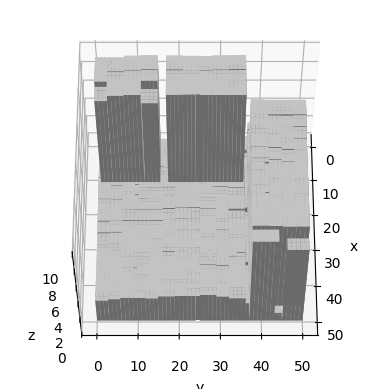

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.bar3d( x_data,
          y_data,
          np.zeros(len(z_data)),
          1, 1, z_data, color = "white")

ax.view_init(60, 0)


plt.show()

# Création et visualisation des triangles (*optionnelles*)

In [ ]:
!pip install trimesh[easy]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 678.6/678.6 KB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.6/107.6 KB 14.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.2/105.2 KB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 KB 2.7 MB/s eta 0:00:00
  Created wheel for pycollada: filename=pycollada-0.7.2-py3-none-any.whl size=127027 sha256=e35612b0b30f013d26719f3677fc01c3f5bda15bbc20f248f47b65dc317e03b8
  Stored in directory: /root/.cache/pip/wheels/1c/ab/7d/4974afa70877d57e24a04aa7cddb765c7899793ed5ba515921
Successfully built pycollada


In [ ]:
import open3d as o3d
import trimesh
import numpy as np

pcd.estimate_normals()

# estimate radius for rolling ball
distances = pcd.compute_nearest_neighbor_distance()
avg_dist = np.mean(distances)
radius = 1.5 * avg_dist   

mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
           pcd,
           o3d.utility.DoubleVector([radius, radius * 2]))

# create the triangular mesh with the vertices and faces from open3d
tri_mesh = trimesh.Trimesh(np.asarray(mesh.vertices), np.asarray(mesh.triangles),
                          vertex_normals=np.asarray(mesh.vertex_normals))

trimesh.convex.is_convex(tri_mesh)

False

In [ ]:
triangles = np.asarray(mesh.triangles)
vertices = np.asarray(mesh.vertices)

In [ ]:
colors = None
if mesh.has_triangle_normals():
    colors = (0.5, 0.5, 0.5) + np.asarray(mesh.triangle_normals) * 0.5
    colors = tuple(map(tuple, colors))
else:
    colors = (1.0, 0.0, 0.0)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import plotly.graph_objects as go
fig = go.Figure(
    data=[
        go.Mesh3d(
            x=vertices[:,0],
            y=vertices[:,1],
            z=vertices[:,2],
            i=triangles[:,0],
            j=triangles[:,1],
            k=triangles[:,2],
            facecolor=colors,
            opacity=0.50)
    ],
    layout=dict(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)
        )
    )
)
fig.show()
img

In [ ]:
import numpy as np
import open3d as o3d

# Load depth map from file
depth_map = np.load('depth_array.npy')

# Create point cloud from depth map
intrinsics = o3d.camera.PinholeCameraIntrinsic(
    depth_map.shape[1], depth_map.shape[0], fx=500, fy=500, cx=depth_map.shape[1]//2, cy=depth_map.shape[0]//2)
depth_image = o3d.geometry.Image(depth_map)
point_cloud = o3d.geometry.PointCloud.create_from_depth_image(depth_image, intrinsics)

# Convert point cloud to mesh
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(point_cloud)


# Save mesh as STL file
o3d.io.write_triangle_mesh("mesh.stl", mesh)


# Création du fichier STL

In [ ]:
!pip3 install numpy-stl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import stl #from numpy-stl
from stl import mesh
import matplotlib.tri as mtri

percent = 100
data = depth_array_h

rand_ints = np.random.randint(0, 100, data.shape[0])
keep_rows = (rand_ints < percent)

data_array = data[keep_rows]

x_data,y_data = np.meshgrid( np.arange(data_array.shape[1]), np.arange(data_array.shape[0]) )

x_data = x_data.flatten()
y_data = y_data.flatten()
z_data = data_array.flatten()



In [ ]:
triang=mtri.Triangulation(x_data, y_data)
data = np.zeros(len(triang.triangles), dtype=mesh.Mesh.dtype)
mobius_mesh = mesh.Mesh(data, remove_empty_areas=False)
mobius_mesh.x[:] = x_data[triang.triangles]
mobius_mesh.y[:] = y_data[triang.triangles]
mobius_mesh.z[:] = z_data[triang.triangles]
mobius_mesh.save('nuitetoilee.stl')

# Visualisation et création d'un modèle 3D

## Visualisation simple à l'aide de `plot_surface` de `matplotlib`

In [ ]:
model3D = depth_array_slic

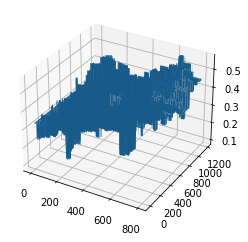

In [ ]:
import numpy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2

nx, ny =  model3D.shape[0],  model3D.shape[1]
x = range(nx)
y = range(ny)

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')

X, Y = numpy.meshgrid(x, y)
ha.plot_surface(X, Y, numpy.transpose(model3D))

plt.show()